# Exploring Event Data for Anomaly Detection

http://datascience.stackexchange.com/questions/6547/open-source-anomaly-detection-in-python

http://machinelearningmastery.com/time-series-data-visualization-with-python/
    

In [5]:
from __future__ import print_function

from azure.storage.table import TableService, Entity
import getpass
import os
import sys
import csv
import numpy as np
import datetime as datetime

In [7]:
loadFromAzure = False

#accountName = 'serviceshubproduswlog'
#dateFloor = '20170101'
#eventIds = np.array(['108']) #registraion reminder = 108
#tableName = 'PremierHubInformation'

accountName = 'profileserviceproduswlog'
dateFloor = '20160101'
eventIds = np.array(['89']) #support contact
tableName = 'SironaInformation'

current_dir = os.getcwd()


## Loads event data from Azure table storage.
Event data is spanned across multiple tables based on severity.  Since we are only analyzing one event at a time, we 
must indicate the tableName and eventId

In [8]:
def getEventIds(accountName, key, tableName, dateFloor, eventId):
    
    table_service = TableService(account_name=accountName, account_key=key)
    
    query = "PartitionKey ge '" + dateFloor + "' and Level eq 8 and EventId eq " + eventId
     
    entities=table_service.query_entities(tableName,
                                          query, 
                                          select="PartitionKey, EventId")
    print ('Writing to ' + fileName)
    
    count = 0
    with open(fileName, 'w+') as csvfile:
        eventWriter = csv.writer(csvfile, delimiter=' ',
                        quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for entity in entities:
            count+=1
            eventWriter.writerow([entity.PartitionKey, entity.EventId.value])
            if count % 100 == 1:
                print('.')
            else:
                print('.', end='')
    print()
    print ('Completed Writing ' + str(count) + ' lines to ' + fileName) 


In [9]:
if loadFromAzure:
    for eventId in eventIds:
        fileName =  current_dir + '/' + tableName + '_eventId_' + eventId + '.csv'
        getEventIds(accountName, getpass.getpass(), tableName, dateFloor, eventId)


## Take a look at the top few imported rows of data

In [10]:
import pandas as pd
from matplotlib import pyplot
tableNameToAnalyze = tableName
eventIdToAnalyze = eventIds[0]
fileName = current_dir + '/' + tableNameToAnalyze + '_eventId_' + eventIdToAnalyze + '.csv'

events = pd.read_csv(fileName, delim_whitespace=True, dtype={'PartitionKey': object, 'EventId': object}, names = ["PartitionKey", "EventId"])
print(events.head())

  PartitionKey EventId
0     20161222      89
1     20161227      89
2     20161227      89
3     20161227      89
4     20161227      89


## Generate date range for every day since first event

In [11]:
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + datetime.timedelta(n)

end_date = datetime.date.today()
start = events['PartitionKey'][0]
start_date = datetime.date(int(start[0:4]), int(start[4:6]), int(start[6:8]))

partition_range = []
for single_date in daterange(start_date, end_date):
    partition_range.append(single_date.strftime('%Y%m%d')) 

partition_array = np.zeros((len(partition_range), 2), dtype=object)

eventsByDay = events.groupby(['PartitionKey'])

partition_array[:,0] = partition_range[:]

for x, y in eventsByDay.PartitionKey:
    partition_array[np.where(partition_array==x)[0],1] = y.count()

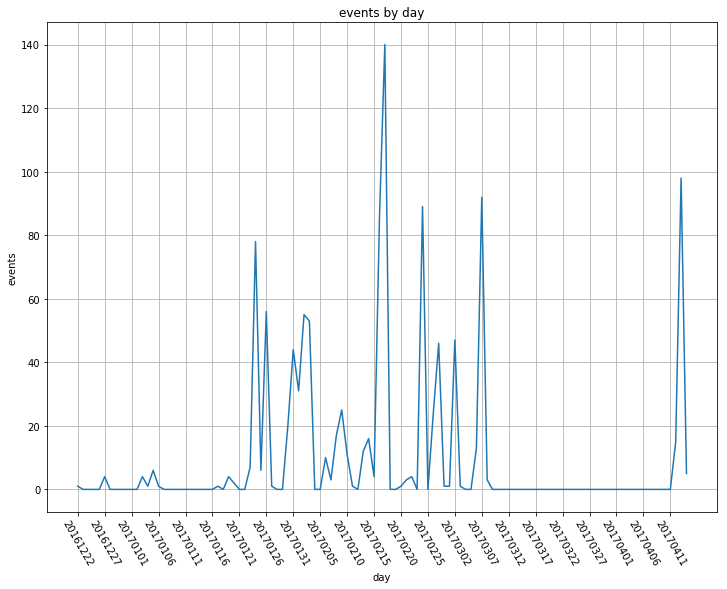

In [52]:
from matplotlib import pyplot as plt

# set chart size
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

i, j = partition_array.shape

plt.plot(partition_array[:,1])
plt.title('events by day')
plt.ylabel('events')
plt.xlabel('day')

step_size = 5
plt.xticks([p for p in range(0,i,step_size)], partition_array[0::step_size, 0])
locs, labels = plt.xticks()
plt.setp(labels, rotation=-60)

plt.grid(True)
plt.show()
